In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cleandata import add_impact_score, get_data, plot_grouped_impact_scores, remove_outliers

In [34]:
df = get_data()
df = add_impact_score(df)
df = remove_outliers(df)

/home/ivan/Desktop/qs80tec-prediction/cleandata.py:8: DtypeWarning: Columns (29,30,35,44,45,50,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('80QS.csv')


Removed 51 outliers with impact score above 15099.488000000012
up: 51, new: 25307
new: 25358


/home/ivan/Desktop/qs80tec-prediction/cleandata.py:205: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='años de graduación', y='impact_score',


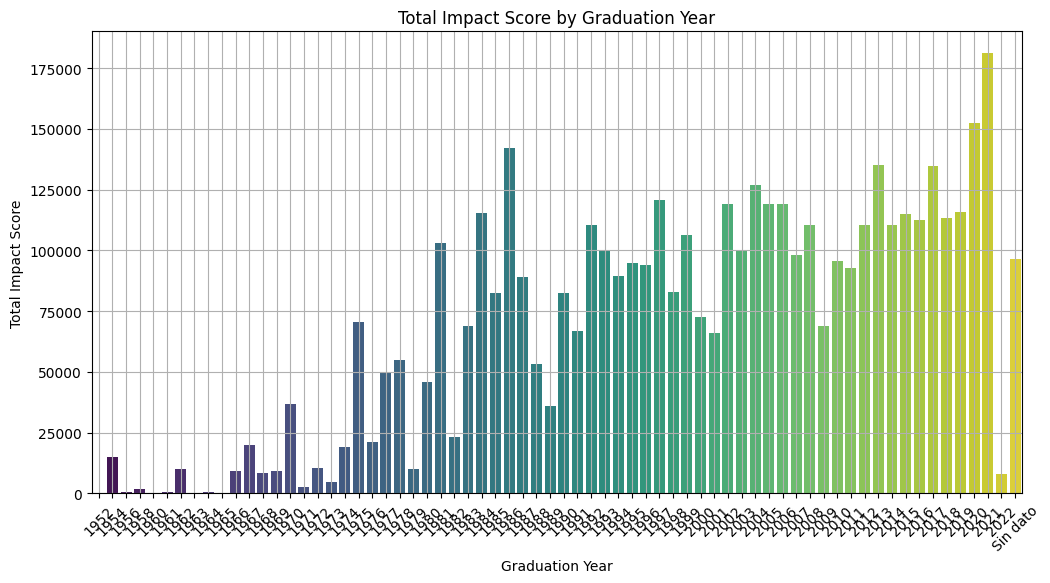

In [35]:
plot_grouped_impact_scores(df)

/home/ivan/Desktop/qs80tec-prediction/cleandata.py:8: DtypeWarning: Columns (29,30,35,44,45,50,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('80QS.csv')


Removed 51 outliers with impact score above 15099.488000000012
up: 51, new: 25307
new: 25358
Rows remaining after filtering: 25011


/home/ivan/Desktop/qs80tec-prediction/cleandata.py:205: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='años de graduación', y='impact_score',


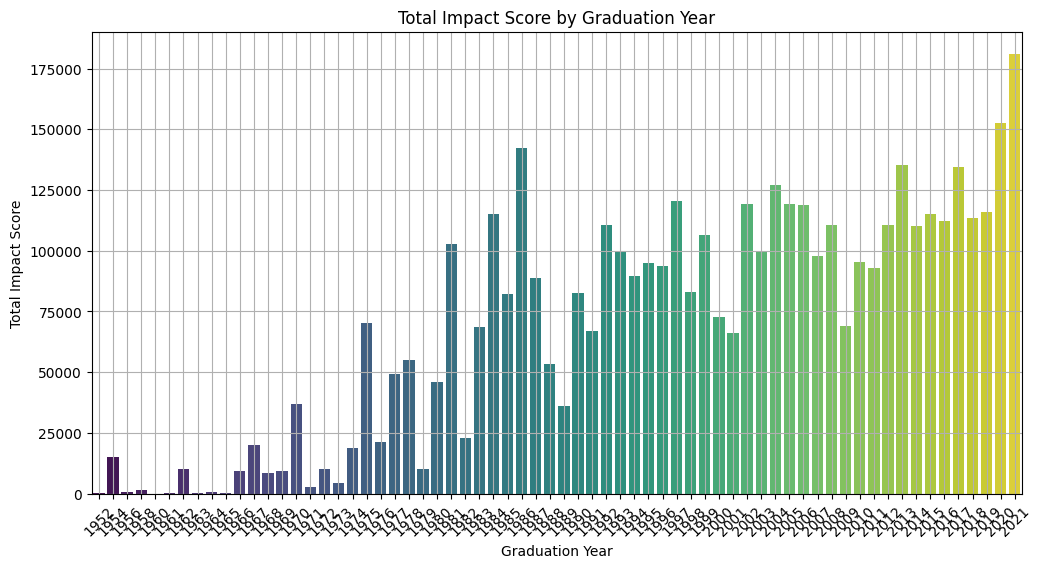

In [36]:
# First, let's reload the data to see what we're working with
df = get_data()
df = add_impact_score(df)
df = remove_outliers(df)

# Check the unique values in graduation year column
# print("Unique graduation years:")
# print(df['años de graduación'].value_counts())
# print(f"\nTotal rows before filtering: {len(df)}")

# Check how many rows would be removed
# rows_to_remove = df[(df['años de graduación'] == 2022) | (df['años de graduación'] == 'Sin dato')]
# print(f"Rows that would be removed: {len(rows_to_remove)}")

# Apply the filter
df_filtered = df[~((df['años de graduación'] == '2022') |
                   (df['años de graduación'] == 'Sin dato'))]
print(f"Rows remaining after filtering: {len(df_filtered)}")

# Plot with the filtered data
if len(df_filtered) > 0:
    plot_grouped_impact_scores(df_filtered)
else:
    print("No data remaining after filtering. Consider adjusting the filter criteria.")

In [37]:
print(1, len(pd.read_csv('80QS.csv')))
print(2, len(df_filtered))

1 25358
2 25011


/tmp/ipykernel_21136/3447309226.py:1: DtypeWarning: Columns (29,30,35,44,45,50,55) have mixed types. Specify dtype option on import or set low_memory=False.
  print(1, len(pd.read_csv('80QS.csv')))


/tmp/ipykernel_21136/1316195197.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=X, y=Y, palette='viridis')


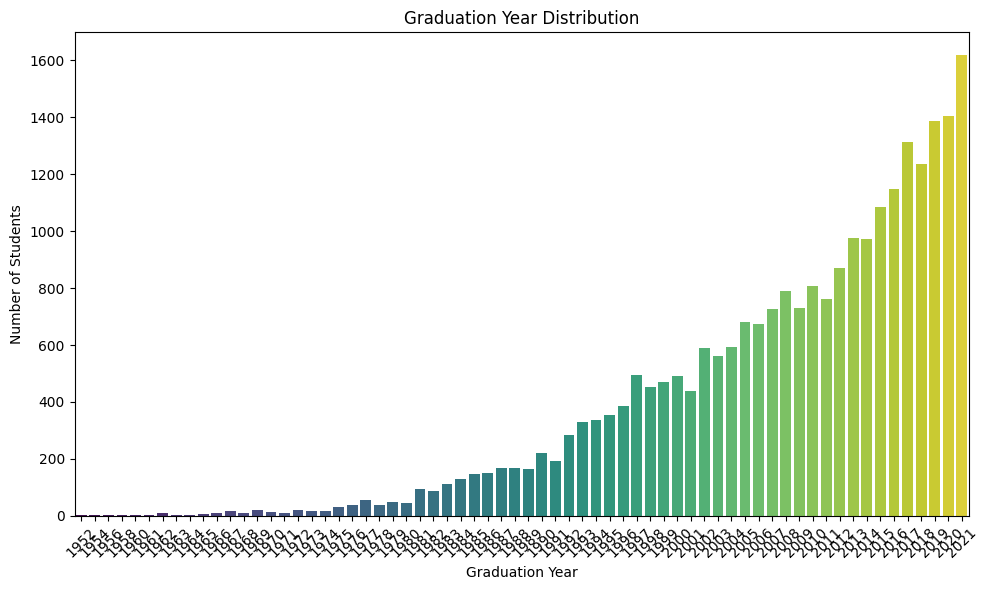

In [38]:
X, Y = np.unique(df_filtered['años de graduación'], return_counts=True)
plt.figure(figsize=(10, 6))
sns.barplot(x=X, y=Y, palette='viridis')
plt.title('Graduation Year Distribution')
plt.xlabel('Graduation Year')
plt.ylabel('Number of Students')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('graduation_year_distribution.png')
plt.show()

Mean Squared Error: 453752837.8534517
R-squared: 0.23136773131182753


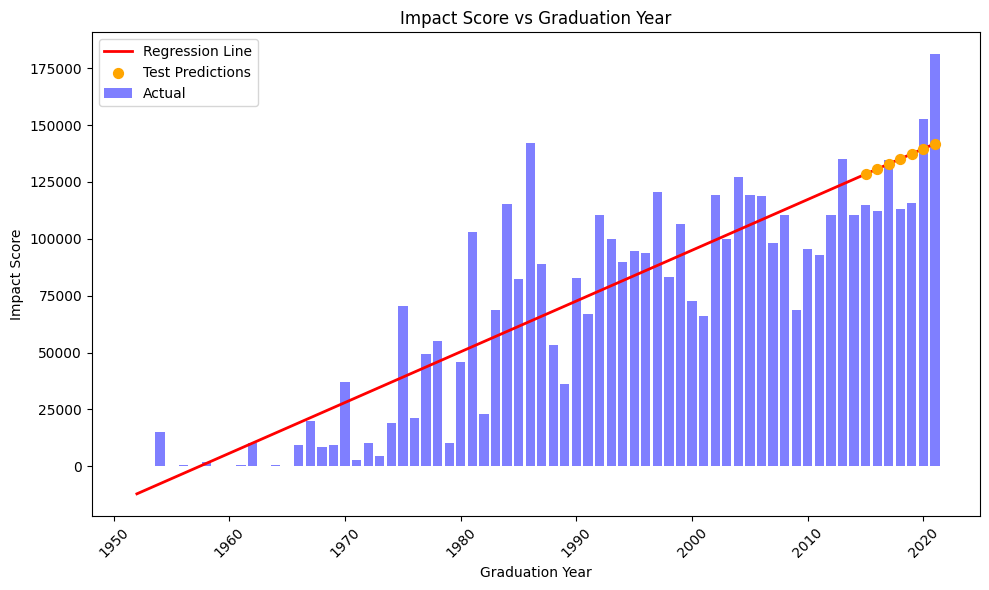

In [39]:
# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Prepare the data for regression
grouped = df_filtered.groupby('años de graduación')[
    'impact_score'].sum().reset_index()
X = grouped['años de graduación'].values.reshape(-1, 1)
y = grouped['impact_score'].values
# Convert years to numeric values
X = X.astype(float)
# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(
# X, y, test_size=0.2, random_state=42)

# Use the first 90% of the data for training and the last 10% for testing
split_index = int(len(X) * 0.9)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Create and fit the model
model = LinearRegression()
model.fit(X_train, y_train)
# Make predictions
y_pred = model.predict(X_test)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')
# Plot the regression results
plt.figure(figsize=(10, 6))
# Plot actual data as bars
plt.bar(X.flatten(), y, color='blue', alpha=0.5, label='Actual')
# Plot regression line
X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_range_pred = model.predict(X_range)
plt.plot(X_range.flatten(), y_range_pred, color='red',
         linewidth=2, label='Regression Line')
# Plot test predictions
plt.scatter(X_test.flatten(), y_pred, color='orange',
            s=50, label='Test Predictions', zorder=5)
plt.title('Impact Score vs Graduation Year')
plt.xlabel('Graduation Year')
plt.ylabel('Impact Score')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('impact_score_vs_graduation_year.png')
plt.show()

Grouped Data for ARIMA:
                    impact_score
años de graduación              
1952-01-01               240.000
1954-01-01             15099.488
1956-01-01               740.000
1958-01-01              1710.000
1960-01-01                40.000
ARIMA Forecast for the next 5 years:
66    157600.328064
67    161878.425745
68    145821.026815
69    135774.131699
70    162591.911292
Name: predicted_mean, dtype: float64


/home/ivan/Desktop/qs80tec-prediction/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ivan/Desktop/qs80tec-prediction/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ivan/Desktop/qs80tec-prediction/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ivan/Desktop/qs80tec-prediction/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is availab

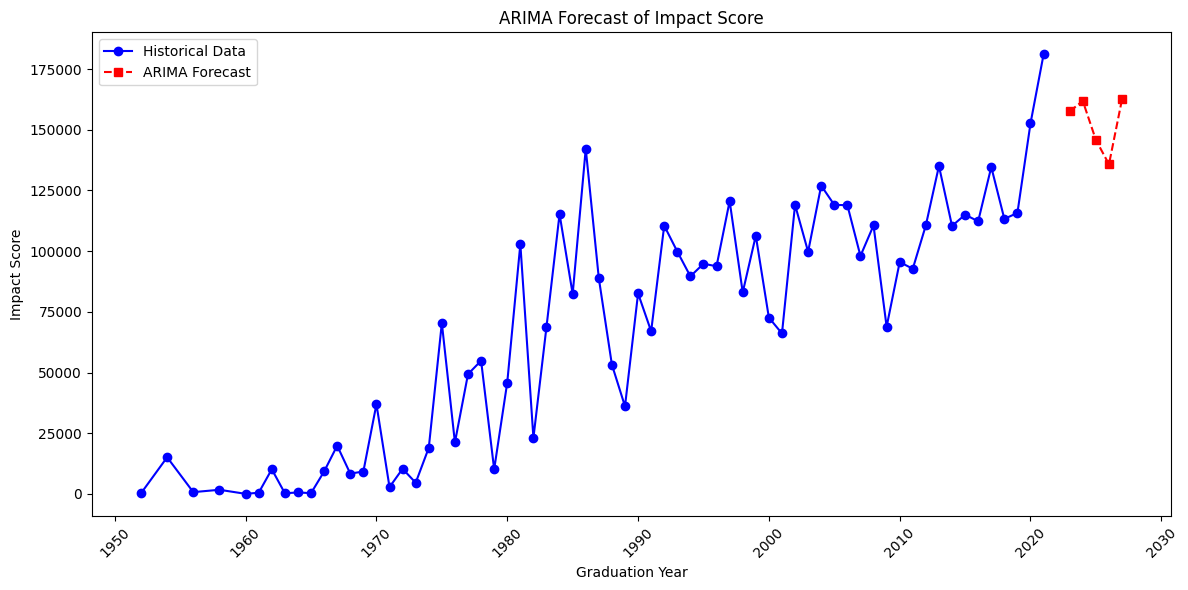


Detailed Forecast:
Year 2022: 157600.33
Year 2023: 161878.43
Year 2024: 145821.03
Year 2025: 135774.13
Year 2026: 162591.91


In [40]:
# ARIMA model
from statsmodels.tsa.arima.model import ARIMA
# Prepare the data for ARIMA
grouped = df_filtered.groupby('años de graduación')[
    'impact_score'].sum().reset_index()
# Convert years to datetime format
grouped['años de graduación'] = pd.to_datetime(
    grouped['años de graduación'], format='%Y', errors='coerce')
# Set the index to the graduation year
grouped.set_index('años de graduación', inplace=True)
# Ensure the index is sorted
grouped.sort_index(inplace=True)
print("Grouped Data for ARIMA:")
print(grouped.head())
# Fit the ARIMA model
model = ARIMA(grouped['impact_score'], order=(0, 1, 5))
model_fit = model.fit()
# Make predictions
# for each year in the next 5 years
forecast = model_fit.forecast(steps=5)
# Print the forecasted values
print("ARIMA Forecast for the next 5 years:")
print(forecast)
# Create future dates for forecasting
last_date = grouped.index[-1]
future_dates = pd.date_range(
    start=last_date + pd.DateOffset(years=1), periods=5, freq='YE')

plt.figure(figsize=(12, 6))
# Plot historical data using the index (which is now the datetime)
plt.plot(grouped.index, grouped['impact_score'],
         label='Historical Data', color='blue', marker='o')

# Plot forecast
plt.plot(future_dates, forecast,
         label='ARIMA Forecast', color='red', marker='s', linestyle='--')

plt.title('ARIMA Forecast of Impact Score')
plt.xlabel('Graduation Year')
plt.ylabel('Impact Score')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('arima_forecast_impact_score.png')
plt.show()

# Print the forecast with corresponding years
print("\nDetailed Forecast:")
for i, (date, value) in enumerate(zip(future_dates, forecast)):
    print(f"Year {date.year}: {value:.2f}")

SVR Mean Squared Error: 359231983.1854855
SVR R-squared: 0.3914808433432022


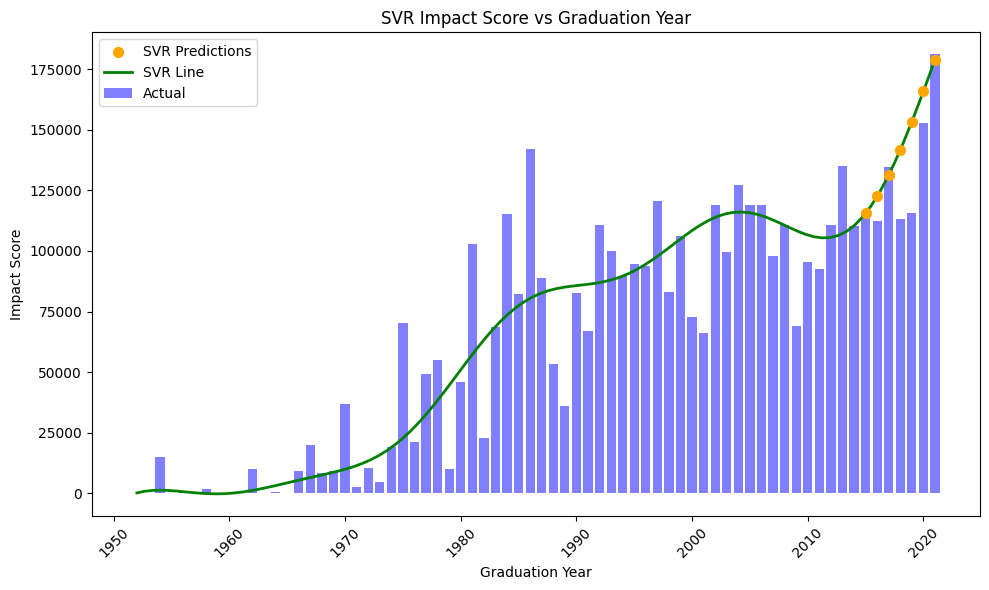


SVR Forecast for the next 5 years:
Year 2022: 191765.90
Year 2023: 204137.89
Year 2024: 215498.19
Year 2025: 225427.58
Year 2026: 233574.87
Year 2027: 239671.83
Year 2028: 243542.26
Year 2029: 245105.06
Year 2030: 244371.78


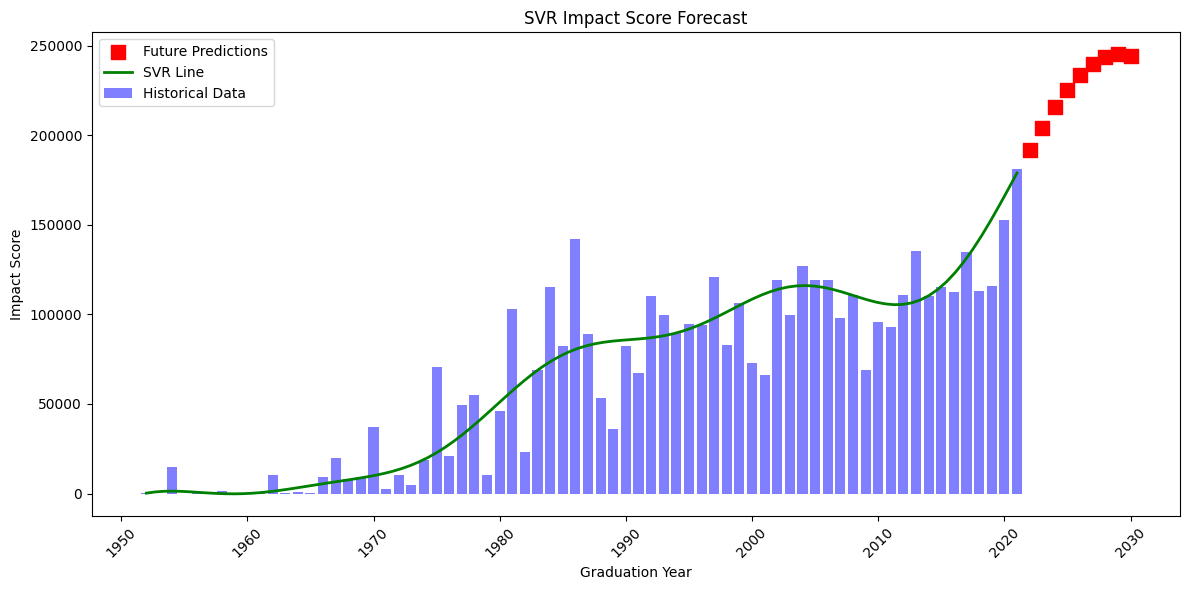

In [41]:
# Support Vector Regression (SVR)
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

# Prepare the data for SVR - use year values instead of datetime
grouped_reset = grouped.reset_index()
grouped_reset['year'] = grouped_reset['años de graduación'].dt.year

X = grouped_reset['year'].values.reshape(-1, 1)
y = grouped_reset['impact_score'].values

# Scale the features for better SVR performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(
#     X_scaled, y, test_size=0.2, random_state=42)
len_data = len(X_scaled)
X_train, X_test, y_train, y_test = X_scaled[:int(
    len_data*0.9)], X_scaled[int(len_data*0.9):], y[:int(len_data*0.9)], y[int(len_data*0.9):]

# Create and fit the SVR model
svr_model = SVR(kernel='rbf', C=10000000, gamma='scale', epsilon=0.1)
svr_model.fit(X_train, y_train)

# Make predictions
y_svr_pred = svr_model.predict(X_test)

# Evaluate the SVR model
mse_svr = mean_squared_error(y_test, y_svr_pred)
r2_svr = r2_score(y_test, y_svr_pred)
print(f'SVR Mean Squared Error: {mse_svr}')
print(f'SVR R-squared: {r2_svr}')

# Plot the SVR results
plt.figure(figsize=(10, 6))

# Plot actual data as bars using year values
years = grouped_reset['year'].values
plt.bar(years, y, color='blue', alpha=0.5, label='Actual')

# Get corresponding years for test predictions
X_test_years = scaler.inverse_transform(X_test)
plt.scatter(X_test_years.flatten(), y_svr_pred, color='orange',
            s=50, label='SVR Predictions', zorder=5)

# Plot SVR line
X_range = np.linspace(years.min(), years.max(), 100).reshape(-1, 1)
X_range_scaled = scaler.transform(X_range)
y_svr_range_pred = svr_model.predict(X_range_scaled)
plt.plot(X_range.flatten(), y_svr_range_pred,
         color='green', linewidth=2, label='SVR Line')

plt.title('SVR Impact Score vs Graduation Year')
plt.xlabel('Graduation Year')
plt.ylabel('Impact Score')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Predict 5 more years into the future
future_years = np.array([2022, 2023, 2024, 2025, 2026,
                        2027, 2028, 2029, 2030]).reshape(-1, 1)
future_years_scaled = scaler.transform(future_years)
future_predictions = svr_model.predict(future_years_scaled)

print("\nSVR Forecast for the next 5 years:")
for year, prediction in zip(future_years.flatten(), future_predictions):
    print(f"Year {year}: {prediction:.2f}")

# Plot with future predictions
plt.figure(figsize=(12, 6))
plt.bar(years, y, color='blue', alpha=0.5, label='Historical Data')
plt.scatter(future_years.flatten(), future_predictions,
            color='red', s=100, label='Future Predictions', marker='s')
plt.plot(X_range.flatten(), y_svr_range_pred,
         color='green', linewidth=2, label='SVR Line')

plt.title('SVR Impact Score Forecast')
plt.xlabel('Graduation Year')
plt.ylabel('Impact Score')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Random Forest Mean Squared Error: 877681461.9162475
Random Forest R-squared: -0.48674396495150285


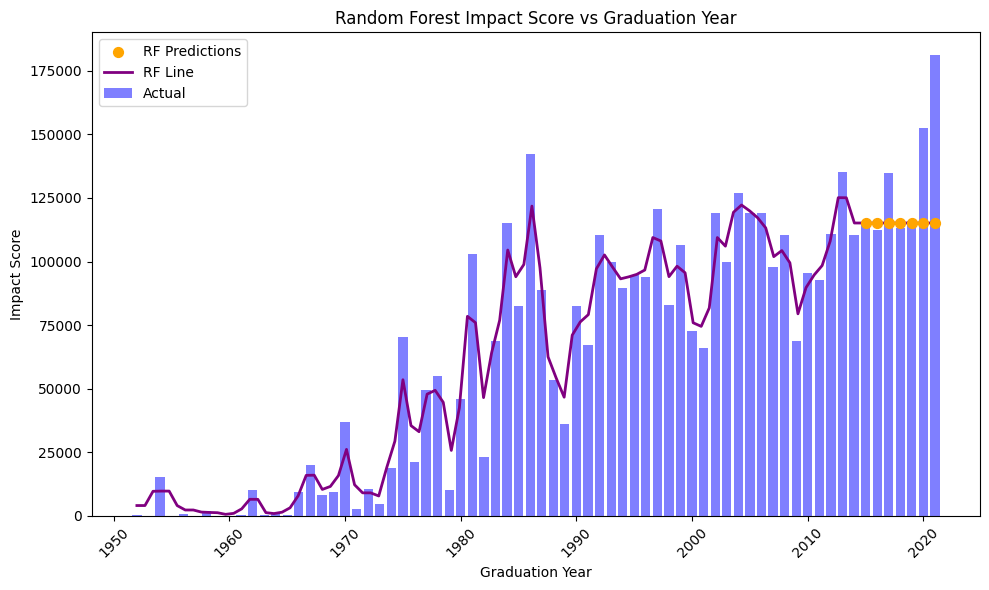


Model Comparison:
Linear Regression - Mean Squared Error: 453752837.85, R-squared: 0.23
SVR - Mean Squared Error: 359231983.19, R-squared: 0.39
Random Forest - Mean Squared Error: 877681461.92, R-squared: -0.49


In [42]:
# Random Forest Regression
from sklearn.ensemble import RandomForestRegressor
# Create and fit the Random Forest model
rf_model = RandomForestRegressor(n_estimators=1000)
rf_model.fit(X_train, y_train)
# Make predictions
y_rf_pred = rf_model.predict(X_test)
# Evaluate the Random Forest model
mse_rf = mean_squared_error(y_test, y_rf_pred)
r2_rf = r2_score(y_test, y_rf_pred)
print(f'Random Forest Mean Squared Error: {mse_rf}')
print(f'Random Forest R-squared: {r2_rf}')
# Plot the Random Forest results
plt.figure(figsize=(10, 6))
# Plot actual data as bars using year values
plt.bar(years, y, color='blue', alpha=0.5, label='Actual')
# Get corresponding years for test predictions
X_test_years = scaler.inverse_transform(X_test)
plt.scatter(X_test_years.flatten(), y_rf_pred, color='orange',
            s=50, label='RF Predictions', zorder=5)
# Plot Random Forest line
X_range = np.linspace(years.min(), years.max(), 100).reshape(-1, 1)
X_range_scaled = scaler.transform(X_range)
y_rf_range_pred = rf_model.predict(X_range_scaled)
plt.plot(X_range.flatten(), y_rf_range_pred,
         color='purple', linewidth=2, label='RF Line')
plt.title('Random Forest Impact Score vs Graduation Year')
plt.xlabel('Graduation Year')
plt.ylabel('Impact Score')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Compare models
models = {
    'Linear Regression': (mse, r2),
    'SVR': (mse_svr, r2_svr),
    'Random Forest': (mse_rf, r2_rf)
}
print("\nModel Comparison:")
for model_name, (mse_value, r2_value) in models.items():
    print(f"{model_name} - Mean Squared Error: {mse_value:.2f}, R-squared: {r2_value:.2f}")

Epoch 1/1000


/home/ivan/Desktop/qs80tec-prediction/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 4108625408.0000 - mae: 48732.7109 - val_loss: 10557935616.0000 - val_mae: 100589.5000
Epoch 2/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 4108625408.0000 - mae: 48732.7109 - val_loss: 10557935616.0000 - val_mae: 100589.5000
Epoch 2/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4108609280.0000 - mae: 48732.4766 - val_loss: 10557881344.0000 - val_mae: 100589.2266
Epoch 3/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4108609280.0000 - mae: 48732.4766 - val_loss: 10557881344.0000 - val_mae: 100589.2266
Epoch 3/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4108581888.0000 - mae: 48731.9609 - val_loss: 10557794304.0000 - val_mae: 100588.7969
Epoch 4/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4108581888.0000 - mae: 48731.9609 - val_loss: 10557794304.0000 - val_mae: 100588.7969
Epoch 4/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4108537088.0000 - mae: 48731.1602 - val_loss: 10557646848.0000 - val_mae: 100588.054

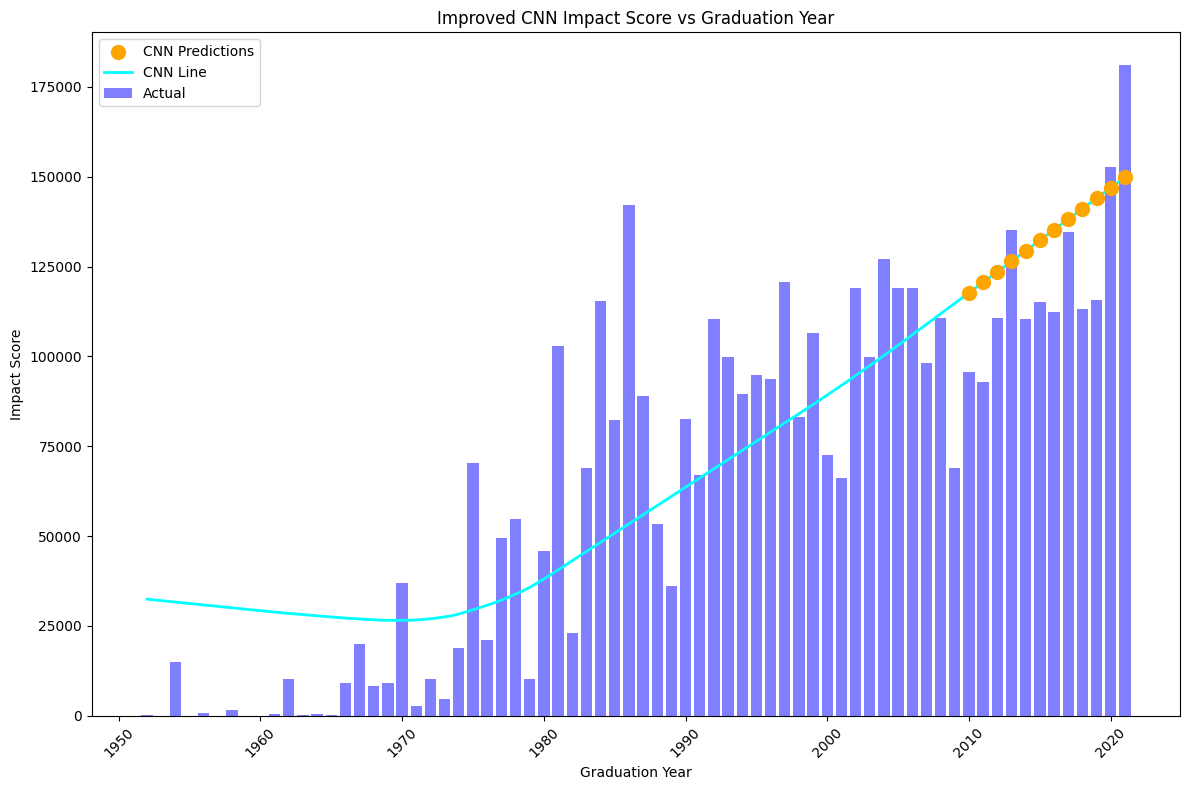

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

CNN Forecast for future years:
Year 2022: 152774.53
Year 2023: 155698.05
Year 2024: 158621.55
Year 2025: 161545.03
Year 2026: 164468.55
Year 2027: 167392.05
Year 2028: 170315.55
Year 2029: 173239.05
Year 2030: 176162.55

Updated Model Comparison:
Linear Regression - MSE: 453752837.85, R-squared: 0.2314
SVR - MSE: 359231983.19, R-squared: 0.3915
Random Forest - MSE: 877681461.92, R-squared: -0.4867
Improved CNN - MSE: 440372464.29, R-squared: 0.2271
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

CNN Forecast for future years:
Year 2022: 152774.53
Year 2023: 155698.05
Year 2024: 158621.55
Year 2025: 161545.03
Year 2026: 164468.55
Year 2027: 167392.05
Year 2028: 170315.55
Year 2029: 173239.05
Year 2030: 176162.55

Updated Model Comparison:
Linear Regression - MSE: 453752837.85, R-squared: 0.2314
SVR - MSE: 359231983.19, R-squared: 0.3915
Random Forest - MSE: 877681461.92, R-squared: -0.4867
Improved CNN - MSE: 440372464.29, R-squared: 0.2271


In [43]:
# Deep Learning - Improved CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Set random seed for reproducibility
tf.random.set_seed(42)

# Prepare the data for CNN with better preprocessing
# Use the scaled data from SVR
# Reshape for CNN (samples, timesteps, features)
X_cnn = X_scaled.reshape(-1, 1, 1)
y_cnn = y

# Use the same train/test split as other models for fair comparison
X_cnn_train = X_cnn[:len_data//10*9]
X_cnn_test = X_cnn[len_data//10*9:]
y_cnn_train = y_cnn[:len_data//10*9]
y_cnn_test = y_cnn[len_data//10*9:]

# Create an improved CNN model
cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(1, 1)),
    Dropout(0.3),
    Conv1D(filters=64, kernel_size=1, activation='relu'),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer
])

# Compile with better parameters
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

# Fit the model with validation split
history = cnn_model.fit(
    X_cnn_train, y_cnn_train,
    epochs=1000,
    batch_size=8,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Make predictions
y_cnn_pred = cnn_model.predict(X_cnn_test).flatten()

# Evaluate the CNN model
mse_cnn = mean_squared_error(y_cnn_test, y_cnn_pred)
r2_cnn = r2_score(y_cnn_test, y_cnn_pred)
print(f'Improved CNN Mean Squared Error: {mse_cnn}')
print(f'Improved CNN R-squared: {r2_cnn}')

# Plot the CNN results
plt.figure(figsize=(12, 8))

# Plot actual data as bars
plt.bar(years, y, color='blue', alpha=0.5, label='Actual')

# Get corresponding years for test predictions
X_cnn_test_years = scaler.inverse_transform(X_cnn_test.reshape(-1, 1))
plt.scatter(X_cnn_test_years.flatten(), y_cnn_pred, color='orange',
            s=100, label='CNN Predictions', zorder=5)

# Plot CNN line for the full range
X_range_cnn = np.linspace(years.min(), years.max(), 100).reshape(-1, 1)
X_range_cnn_scaled = scaler.transform(X_range_cnn).reshape(-1, 1, 1)
y_cnn_range_pred = cnn_model.predict(X_range_cnn_scaled).flatten()
plt.plot(X_range_cnn.flatten(), y_cnn_range_pred,
         color='cyan', linewidth=2, label='CNN Line')

plt.title('Improved CNN Impact Score vs Graduation Year')
plt.xlabel('Graduation Year')
plt.ylabel('Impact Score')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Predict future values
future_years_cnn_scaled = scaler.transform(future_years).reshape(-1, 1, 1)
future_cnn_predictions = cnn_model.predict(future_years_cnn_scaled).flatten()

print("\nCNN Forecast for future years:")
for year, prediction in zip(future_years.flatten(), future_cnn_predictions):
    print(f"Year {year}: {prediction:.2f}")

# Update model comparison
models['Improved CNN'] = (mse_cnn, r2_cnn)
print("\nUpdated Model Comparison:")
for model_name, (mse_value, r2_value) in models.items():
    print(f"{model_name} - MSE: {mse_value:.2f}, R-squared: {r2_value:.4f}")

Transformer Model Architecture:


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 5, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 5, 64)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding_1           │ (None, 5, 64)          │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ (None, 5, 64)          │        83,200 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ (None, 5, 64)          │        83,200 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,169 (715.50 KB)

 Trainable params: 183,169 (715.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 4184651776.0000 - mae: 49072.1094 - val_loss: 11137923072.0000 - val_mae: 103754.1641
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 4184651776.0000 - mae: 49072.1094 - val_loss: 11137923072.0000 - val_mae: 103754.1641
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4184033024.0000 - mae: 49065.4766 - val_loss: 11136457728.0000 - val_mae: 103747.1016
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4184033024.0000 - mae: 49065.4766 - val_loss: 11136457728.0000 - val_mae: 103747.1016
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4183321088.0000 - mae: 49058.8008 - val_loss: 11134120960.0000 - val_mae: 103735.8359
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4183321088.0000 - mae: 49058.8008 - val_loss: 11134120960.0000 - val_mae: 103735.8359
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4182079744.0000 - mae: 49044.8906 - val_loss: 11130166272.0000 -

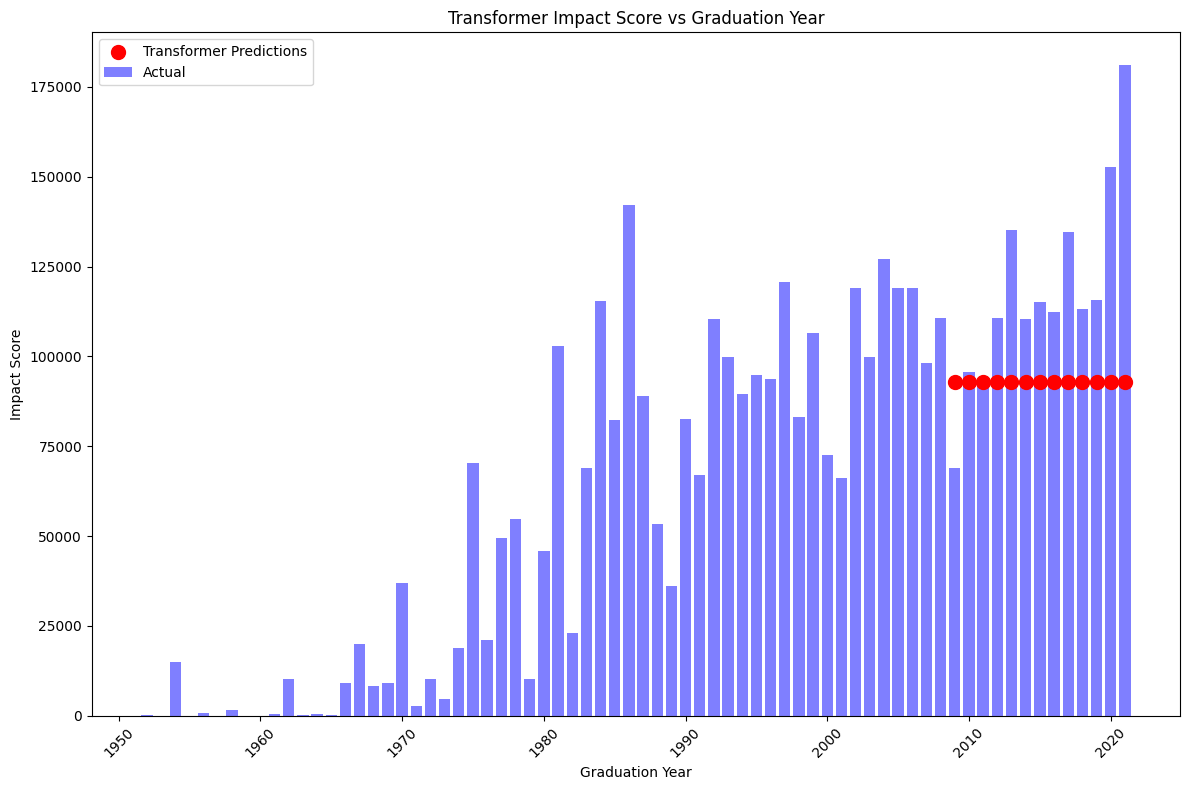

In [44]:
# Transformer Model for Time Series Prediction
import tensorflow as tf
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dense, Dropout, Input
from tensorflow.keras.models import Model
import math


class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, d_model):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.sequence_length = sequence_length

    def call(self, x):
        seq_len = tf.shape(x)[1]
        pos = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]
        dim = tf.range(self.d_model, dtype=tf.float32)[tf.newaxis, :]

        angle_rates = 1 / \
            tf.pow(10000.0, (2 * (dim // 2)) /
                   tf.cast(self.d_model, tf.float32))
        angle_rads = pos * angle_rates

        pos_encoding = tf.concat([
            tf.sin(angle_rads[:, 0::2]),
            tf.cos(angle_rads[:, 1::2])
        ], axis=-1)

        return x + pos_encoding


class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadAttention(
            num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(d_model),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)

    def call(self, inputs, training=None):  # Make training parameter optional
        attn_output = self.attention(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


# Prepare sequence data for Transformer
sequence_length = 5  # Use last 5 years to predict next year
d_model = 64  # Embedding dimension


def create_sequences(X, y, seq_length):
    sequences = []
    targets = []
    for i in range(len(X) - seq_length):
        sequences.append(X[i:i+seq_length])
        targets.append(y[i+seq_length])
    return np.array(sequences), np.array(targets)


# Create sequences from the scaled data
X_seq, y_seq = create_sequences(X_scaled.flatten(), y, sequence_length)
# Add feature dimension
X_seq = X_seq.reshape(X_seq.shape[0], X_seq.shape[1], 1)

# Split data
train_size = int(len(X_seq) * 0.8)
X_seq_train, X_seq_test = X_seq[:train_size], X_seq[train_size:]
y_seq_train, y_seq_test = y_seq[:train_size], y_seq[train_size:]

# Create Transformer model


def create_transformer_model(seq_length, d_model, num_heads=4, ff_dim=128):
    inputs = Input(shape=(seq_length, 1))

    # Project input to d_model dimensions
    x = Dense(d_model)(inputs)

    # Add positional encoding
    x = PositionalEncoding(seq_length, d_model)(x)

    # Transformer blocks
    x = TransformerBlock(d_model, num_heads, ff_dim)(x)
    x = TransformerBlock(d_model, num_heads, ff_dim)(x)

    # Global average pooling
    x = tf.keras.layers.GlobalAveragePooling1D()(x)

    # Final dense layers
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    return model


# Create and compile the model
transformer_model = create_transformer_model(sequence_length, d_model)
transformer_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print("Transformer Model Architecture:")
transformer_model.summary()

# Train the model
if len(X_seq_train) > 0:
    history_transformer = transformer_model.fit(
        X_seq_train, y_seq_train,
        epochs=200,
        batch_size=4,
        validation_split=0.2,
        callbacks=[EarlyStopping(
            monitor='val_loss', patience=30, restore_best_weights=True)],
        verbose=1
    )

    # Make predictions
    y_transformer_pred = transformer_model.predict(X_seq_test).flatten()

    # Evaluate the model
    mse_transformer = mean_squared_error(y_seq_test, y_transformer_pred)
    r2_transformer = r2_score(y_seq_test, y_transformer_pred)
    print(f'Transformer Mean Squared Error: {mse_transformer}')
    print(f'Transformer R-squared: {r2_transformer}')

    # Plot results
    plt.figure(figsize=(12, 8))

    # Plot actual data
    plt.bar(years, y, color='blue', alpha=0.5, label='Actual')

    # Get corresponding years for test predictions
    test_years = years[sequence_length + train_size:]
    if len(test_years) == len(y_transformer_pred):
        plt.scatter(test_years, y_transformer_pred, color='red',
                    s=100, label='Transformer Predictions', zorder=5)

    plt.title('Transformer Impact Score vs Graduation Year')
    plt.xlabel('Graduation Year')
    plt.ylabel('Impact Score')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

else:
    print("Not enough data to create sequences for Transformer model")

Hybrid Model Mean Squared Error: 264662402.3171871
Hybrid Model R-squared: 0.5516764948691684


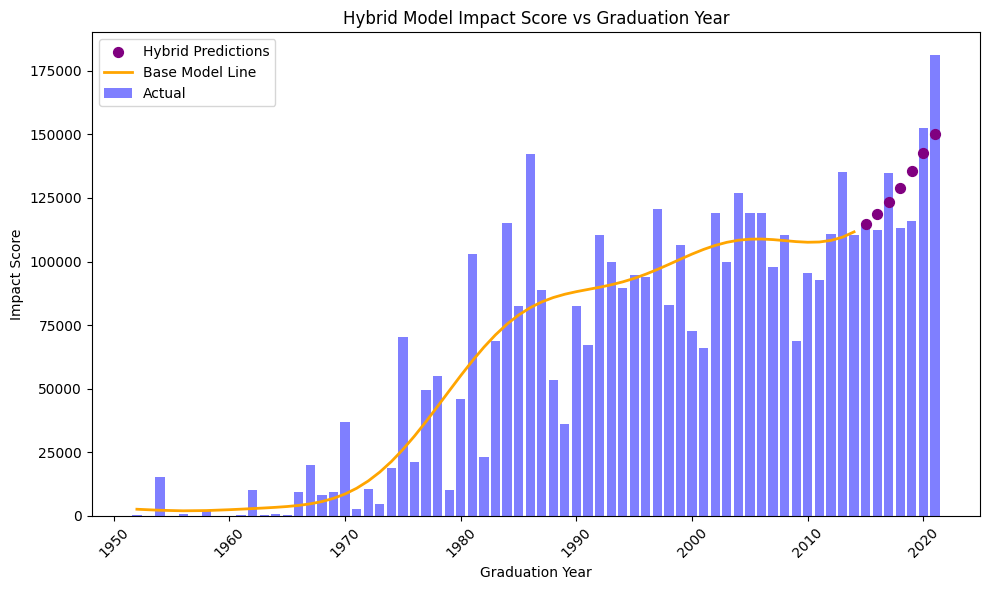


Final Model Comparison with Hybrid Model:
Hybrid Model         - MSE: 264662402.32, R²:   0.5517
SVR                  - MSE: 359231983.19, R²:   0.3915
Improved CNN         - MSE: 440372464.29, R²:   0.2271
Linear Regression    - MSE: 453752837.85, R²:   0.2314
Random Forest        - MSE: 877681461.92, R²:  -0.4867


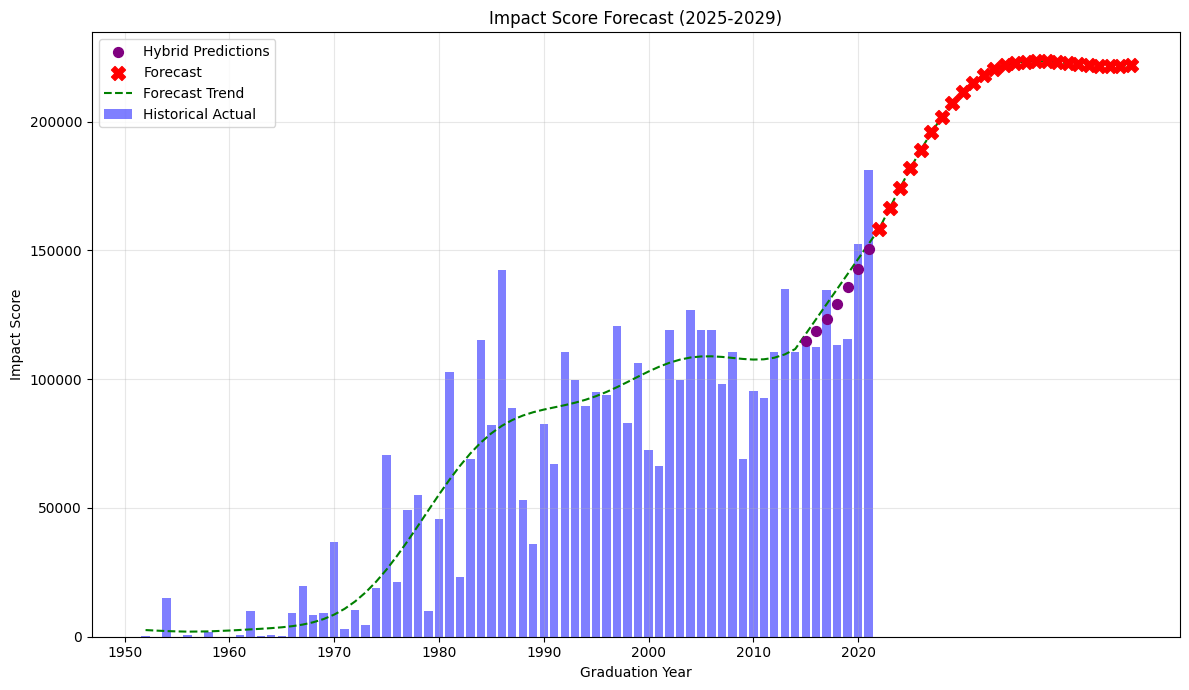

In [45]:
# Step 1: Linear trend as base
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
base_model = LinearRegression().fit(X_train, y_train)
y_base = base_model.predict(X_train)

# Step 2: Model residuals with SVR
residuals = y_train - y_base

# Scale residuals for SVR
scaler_y = StandardScaler()
scaled_residuals = scaler_y.fit_transform(residuals.reshape(-1, 1)).ravel()

# Train SVR on residuals
svr_residual = SVR(kernel='rbf', C=100, epsilon=0.1)
svr_residual.fit(X_train, scaled_residuals)

# Predict residuals
residual_pred = scaler_y.inverse_transform(
    svr_residual.predict(X_test).reshape(-1, 1)
).ravel()


def get_predictions(x):
    """Get predictions from the base model and residuals."""
    base_pred = base_model.predict(x)
    residuals_pred = scaler_y.inverse_transform(
        svr_residual.predict(x).reshape(-1, 1)
    ).ravel()
    return base_pred + residuals_pred


# Step 3: Combined prediction
y_pred_hybrid = get_predictions(X_test)

# Evaluate the hybrid model
mse_hybrid = mean_squared_error(y_test, y_pred_hybrid)
r2_hybrid = r2_score(y_test, y_pred_hybrid)
print(f'Hybrid Model Mean Squared Error: {mse_hybrid}')
print(f'Hybrid Model R-squared: {r2_hybrid}')

# Plot the hybrid model results
plt.figure(figsize=(10, 6))
# Plot actual data as bars using year values
plt.bar(years, y, color='blue', alpha=0.5, label='Actual')
# Get corresponding years for test predictions
X_test_years = scaler.inverse_transform(X_test)
plt.scatter(X_test_years.flatten(), y_pred_hybrid, color='purple',
            s=50, label='Hybrid Predictions', zorder=5)

# Plot hybrid line
X_train_years = scaler.inverse_transform(X_train)
plt.plot(X_train_years.flatten(), get_predictions(X_train),
         color='orange', linewidth=2, label='Base Model Line')
plt.title('Hybrid Model Impact Score vs Graduation Year')
plt.xlabel('Graduation Year')
plt.ylabel('Impact Score')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Add hybrid model to comparison
models['Hybrid Model'] = (mse_hybrid, r2_hybrid)
# Final model comparison
print("\nFinal Model Comparison with Hybrid Model:")
sorted_models = sorted(models.items(), key=lambda x: x[1][0])  # Sort by MSE
for model_name, (mse_value, r2_value) in sorted_models:
    print(f"{model_name:20} - MSE: {mse_value:10.2f}, R²: {r2_value:8.4f}")

# Forecast future values with the hybrid model
last_year = years.max()  # Find most recent year in data
future_years = np.arange(last_year + 1, last_year + 26).reshape(-1, 1)

# Scale future years using the SAME scaler used for training
future_years_scaled = scaler.transform(future_years)

# Hybrid model prediction
future_linear = base_model.predict(future_years_scaled)
future_residuals = svr_residual.predict(future_years_scaled)
# future_predictions = future_linear + future_residuals
future_predictions = get_predictions(future_years_scaled)

plt.figure(figsize=(12, 7))

# Historical actual data
plt.bar(years, y, color='blue', alpha=0.5, label='Historical Actual')

# Historical predictions (from previous plot)
plt.scatter(X_test_years.flatten(), y_pred_hybrid, color='purple',
            s=50, label='Hybrid Predictions', zorder=5)

# Future forecast
plt.scatter(future_years, future_predictions, color='red', s=100,
            marker='X', label='Forecast', zorder=10)

# Trend line extension
extended_years = np.vstack([X_train, future_years_scaled])
extended_hybrid = get_predictions(extended_years)

# Inverse scale years for plotting
extended_years_orig = scaler.inverse_transform(extended_years)
plt.plot(extended_years_orig, extended_hybrid, 'g--', linewidth=1.5,
         label='Forecast Trend')

plt.title('Impact Score Forecast (2025-2029)')
plt.xlabel('Graduation Year')
plt.ylabel('Impact Score')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(np.arange(1950, 2030, 10))
plt.tight_layout()
plt.show()

Training Neural-SVR Hybrid Model...


/home/ivan/Desktop/qs80tec-prediction/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Iteration 10: Combined MSE = 431248844.37, Neural MSE = 5786377921.91, SVR MSE = 431248933.23
Iteration 20: Combined MSE = 431228190.03, Neural MSE = 5786515297.69, SVR MSE = 431228276.50
Iteration 20: Combined MSE = 431228190.03, Neural MSE = 5786515297.69, SVR MSE = 431228276.50
Iteration 30: Combined MSE = 431243012.60, Neural MSE = 5786652864.74, SVR MSE = 431243098.69
Iteration 30: Combined MSE = 431243012.60, Neural MSE = 5786652864.74, SVR MSE = 431243098.69
Iteration 40: Combined MSE = 431244635.03, Neural MSE = 5786788354.97, SVR MSE = 431244719.42
Iteration 40: Combined MSE = 431244635.03, Neural MSE = 5786788354.97, SVR MSE = 431244719.42
Iteration 50: Combined MSE = 431195350.61, Neural MSE = 5786923243.68, SVR MSE = 431195435.85
Iteration 50: Combined MSE = 431195350.61, Neural MSE = 5786923243.68, SVR MSE = 431195435.85
Iteration 60: Combined MSE = 431218316.76, Neural MSE = 5787060681.42, SVR MSE = 431218401.66
Iteration 60: Combined MSE = 431218316.76, Neural MSE = 5787

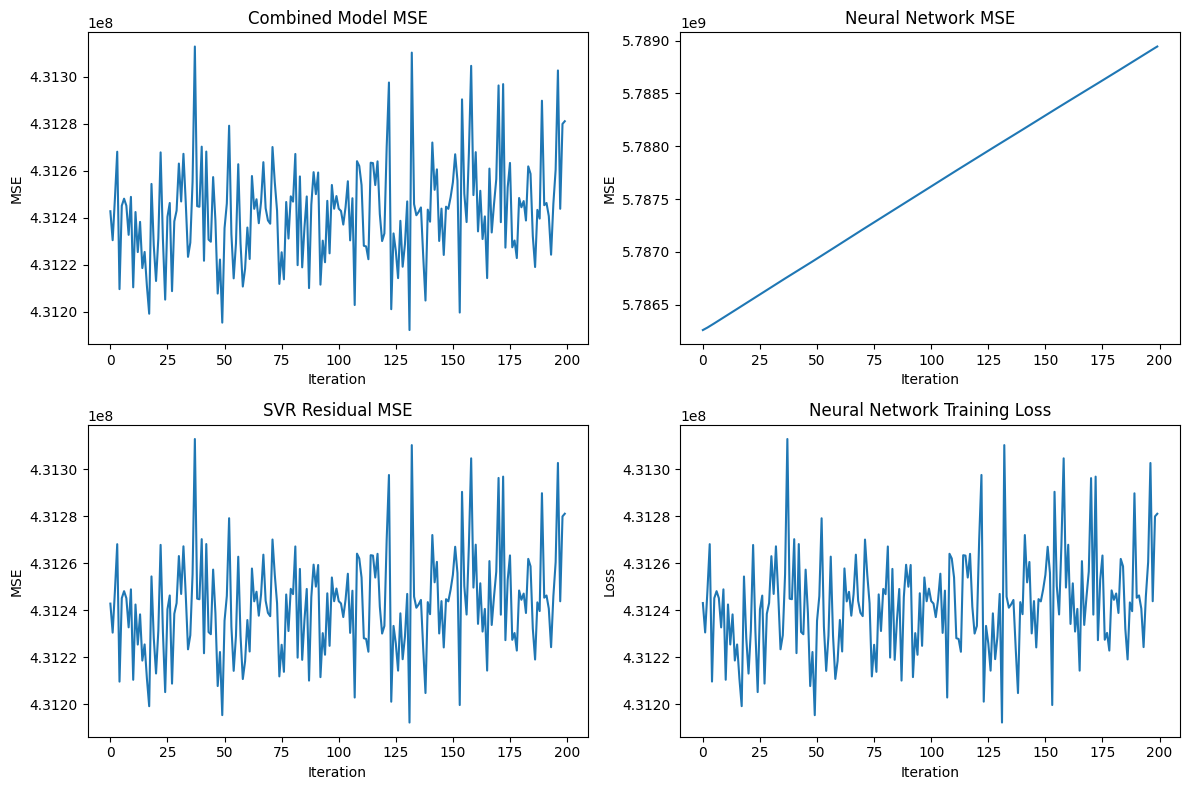

In [47]:
# Neural Network Hybrid Model - Single Neuron + SVR with Iterative Training
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


class NeuralSVRHybrid:
    def __init__(self, learning_rate=0.01, svr_C=100, svr_epsilon=0.1, max_iterations=10):
        self.learning_rate = learning_rate
        self.svr_C = svr_C
        self.svr_epsilon = svr_epsilon
        self.max_iterations = max_iterations
        self.neural_model = None
        self.svr_model = None
        self.scaler_y = StandardScaler()
        self.history = {'loss': [], 'neural_mse': [],
                        'svr_mse': [], 'combined_mse': []}

    def _create_neural_model(self, input_shape):
        """Create a single neuron model"""
        model = Sequential([
            Dense(1, input_shape=(input_shape,),
                  use_bias=True, activation='linear')
        ])
        model.compile(optimizer=Adam(
            learning_rate=self.learning_rate), loss='mse')
        return model

    def fit(self, X_train, y_train, verbose=1):
        """Train the hybrid model iteratively"""
        X_train = np.array(X_train)
        y_train = np.array(y_train)

        # Initialize neural model
        self.neural_model = self._create_neural_model(X_train.shape[1])

        # Initialize with random predictions
        neural_pred = self.neural_model.predict(X_train, verbose=0)

        for iteration in range(self.max_iterations):
            # Step 1: Calculate residuals from current neural network predictions
            residuals = y_train.reshape(-1, 1) - neural_pred

            # Step 2: Train SVR on residuals
            scaled_residuals = self.scaler_y.fit_transform(residuals).ravel()
            self.svr_model = SVR(kernel='rbf', C=self.svr_C,
                                 epsilon=self.svr_epsilon)
            self.svr_model.fit(X_train, scaled_residuals)

            # Step 3: Get SVR predictions on residuals
            svr_residual_pred = self.scaler_y.inverse_transform(
                self.svr_model.predict(X_train).reshape(-1, 1)
            ).ravel()

            # Step 4: Calculate target for neural network (original target - SVR residual correction)
            neural_target = y_train - svr_residual_pred

            # Step 5: Train neural network for one epoch
            history = self.neural_model.fit(
                X_train, neural_target, epochs=1, verbose=0)

            # Step 6: Get new neural network predictions
            neural_pred = self.neural_model.predict(X_train, verbose=0)

            # Step 7: Calculate combined prediction and loss
            combined_pred = neural_pred.ravel() + svr_residual_pred
            combined_mse = mean_squared_error(y_train, combined_pred)
            neural_mse = mean_squared_error(y_train, neural_pred.ravel())
            svr_mse = mean_squared_error(residuals.ravel(), svr_residual_pred)

            # Store metrics
            self.history['loss'].append(history.history['loss'][0])
            self.history['neural_mse'].append(neural_mse)
            self.history['svr_mse'].append(svr_mse)
            self.history['combined_mse'].append(combined_mse)

            if verbose and (iteration + 1) % 10 == 0:
                print(
                    f"Iteration {iteration + 1}: Combined MSE = {combined_mse:.2f}, Neural MSE = {neural_mse:.2f}, SVR MSE = {svr_mse:.2f}")

    def predict(self, X):
        """Make predictions using the hybrid model"""
        neural_pred = self.neural_model.predict(X, verbose=0)
        svr_residual_pred = self.scaler_y.inverse_transform(
            self.svr_model.predict(X).reshape(-1, 1)
        ).ravel()
        return neural_pred.ravel() + svr_residual_pred

    def plot_training_history(self):
        """Plot the training history"""
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))

        axes[0, 0].plot(self.history['combined_mse'])
        axes[0, 0].set_title('Combined Model MSE')
        axes[0, 0].set_xlabel('Iteration')
        axes[0, 0].set_ylabel('MSE')

        axes[0, 1].plot(self.history['neural_mse'])
        axes[0, 1].set_title('Neural Network MSE')
        axes[0, 1].set_xlabel('Iteration')
        axes[0, 1].set_ylabel('MSE')

        axes[1, 0].plot(self.history['svr_mse'])
        axes[1, 0].set_title('SVR Residual MSE')
        axes[1, 0].set_xlabel('Iteration')
        axes[1, 0].set_ylabel('MSE')

        axes[1, 1].plot(self.history['loss'])
        axes[1, 1].set_title('Neural Network Training Loss')
        axes[1, 1].set_xlabel('Iteration')
        axes[1, 1].set_ylabel('Loss')

        plt.tight_layout()
        plt.show()


# Train the Neural-SVR Hybrid Model
print("Training Neural-SVR Hybrid Model...")
neural_svr_hybrid = NeuralSVRHybrid(learning_rate=0.13, max_iterations=200)
neural_svr_hybrid.fit(X_train, y_train, verbose=1)

# Make predictions
y_pred_neural_hybrid = neural_svr_hybrid.predict(X_test)

# Evaluate the model
mse_neural_hybrid = mean_squared_error(y_test, y_pred_neural_hybrid)
r2_neural_hybrid = r2_score(y_test, y_pred_neural_hybrid)

print(f"\nNeural-SVR Hybrid Model Results:")
print(f"Mean Squared Error: {mse_neural_hybrid:.2f}")
print(f"R-squared: {r2_neural_hybrid:.4f}")

# Plot training history
neural_svr_hybrid.plot_training_history()

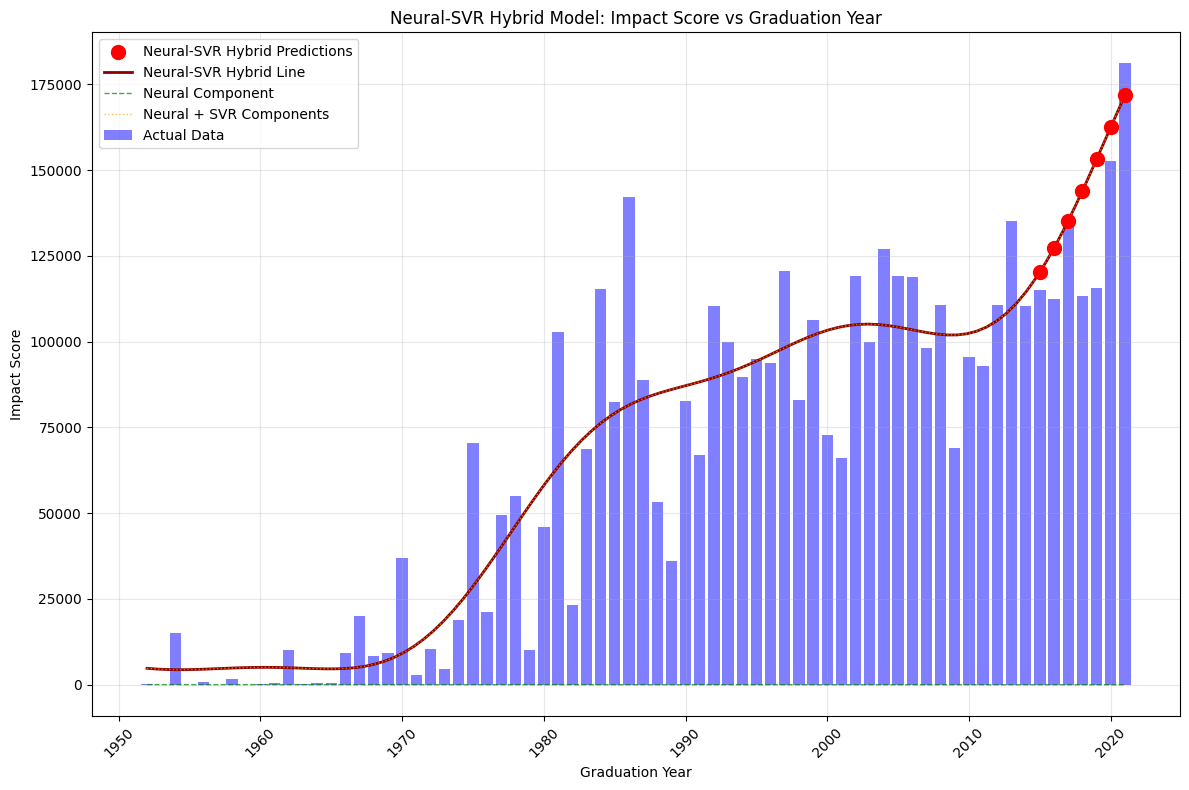


Final Model Comparison:
1. Hybrid Model              - MSE: 264662402.32, R²:   0.5517
2. CNN-SVR Hybrid            - MSE: 292578251.64, R²:   0.4865
3. SVR                       - MSE: 359231983.19, R²:   0.3915
4. Neural-SVR Hybrid         - MSE: 395298807.74, R²:   0.3304
5. Improved CNN              - MSE: 440372464.29, R²:   0.2271
6. Linear Regression         - MSE: 453752837.85, R²:   0.2314
7. Random Forest             - MSE: 877681461.92, R²:  -0.4867

Improvement over Linear-SVR Hybrid: -49.36%


In [62]:
# Visualize the Neural-SVR Hybrid Model Results
plt.figure(figsize=(12, 8))

# Plot actual data
plt.bar(years, y, color='blue', alpha=0.5, label='Actual Data')

# Plot test predictions
X_test_years = scaler.inverse_transform(X_test)
plt.scatter(X_test_years.flatten(), y_pred_neural_hybrid,
            color='red', s=100, label='Neural-SVR Hybrid Predictions', zorder=5)

# Plot prediction line for full range
X_range = np.linspace(years.min(), years.max(), 100).reshape(-1, 1)
X_range_scaled = scaler.transform(X_range)
y_range_pred_neural_hybrid = neural_svr_hybrid.predict(X_range_scaled)
plt.plot(X_range.flatten(), y_range_pred_neural_hybrid,
         color='darkred', linewidth=2, label='Neural-SVR Hybrid Line')

# Get component predictions for visualization
neural_component = neural_svr_hybrid.neural_model.predict(
    X_range_scaled, verbose=0).ravel()
svr_component = neural_svr_hybrid.scaler_y.inverse_transform(
    neural_svr_hybrid.svr_model.predict(X_range_scaled).reshape(-1, 1)
).ravel()

plt.plot(X_range.flatten(), neural_component,
         color='green', linewidth=1, linestyle='--', alpha=0.7, label='Neural Component')
plt.plot(X_range.flatten(), neural_component + svr_component,
         color='orange', linewidth=1, linestyle=':', alpha=0.7, label='Neural + SVR Components')

plt.title('Neural-SVR Hybrid Model: Impact Score vs Graduation Year')
plt.xlabel('Graduation Year')
plt.ylabel('Impact Score')
plt.legend()
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Compare all models including the new neural hybrid
models['Neural-SVR Hybrid'] = (mse_neural_hybrid, r2_neural_hybrid)

print("\nFinal Model Comparison:")
print("=" * 60)
sorted_models = sorted(models.items(), key=lambda x: x[1][0])  # Sort by MSE
for i, (model_name, (mse_value, r2_value)) in enumerate(sorted_models, 1):
    print(f"{i}. {model_name:25} - MSE: {mse_value:10.2f}, R²: {r2_value:8.4f}")

# Show improvement over original hybrid
original_hybrid_mse = models['Hybrid Model'][0]
improvement = ((original_hybrid_mse - mse_neural_hybrid) /
               original_hybrid_mse) * 100
print(f"\nImprovement over Linear-SVR Hybrid: {improvement:.2f}%")

Generating future predictions with Neural-SVR Hybrid Model...

Future Predictions (2022-2027):
Year	Neural		SVR		Combined
--------------------------------------------------
2022	   -34.5	180628.5	180593.9
2023	   -35.1	188750.4	188715.4
2024	   -35.6	195878.8	195843.3
2025	   -36.1	201785.5	201749.4


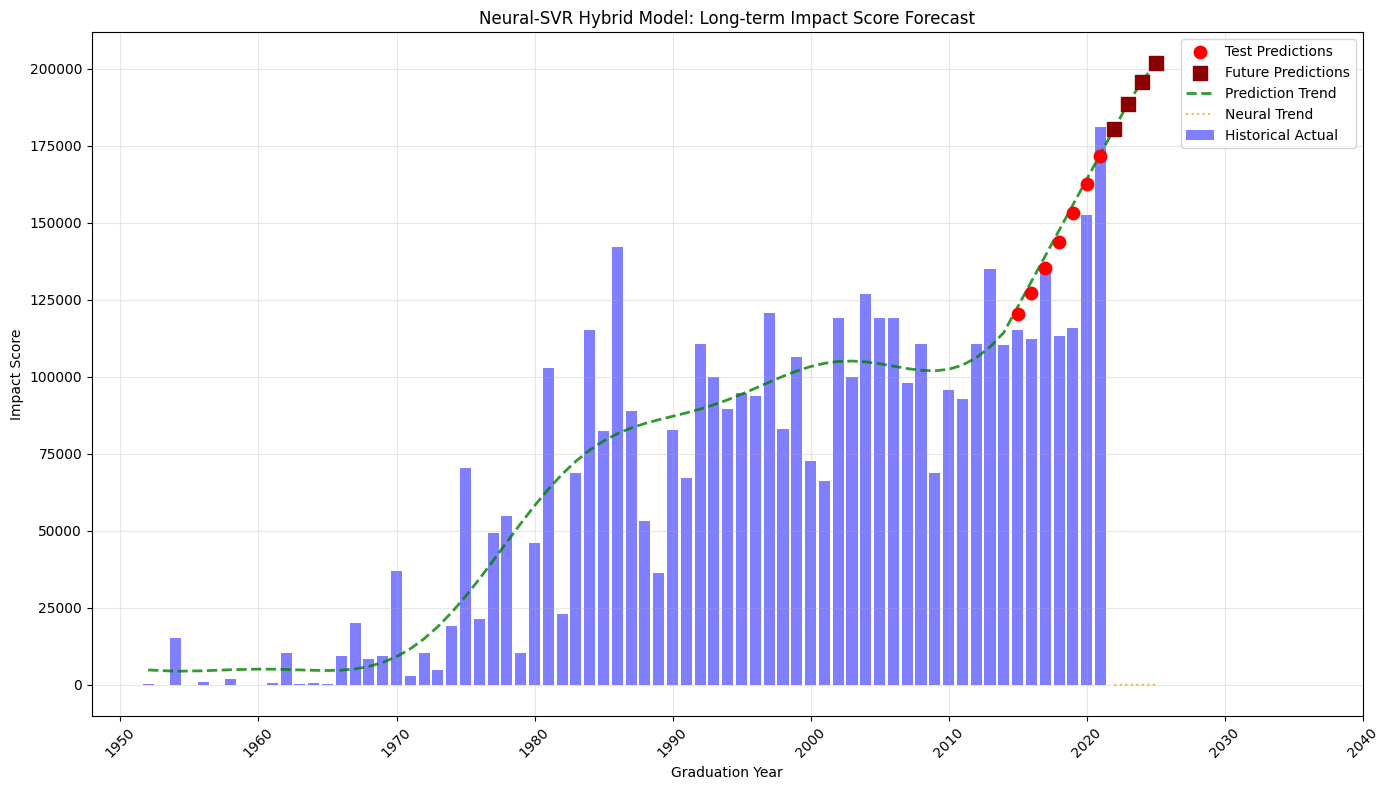


Prediction Analysis:
Neural component contribution range: -36.1 to -34.5
SVR component contribution range: 180628.5 to 201785.5
Total prediction range: 180593.9 to 201749.4

First 10 years of predictions:
   Year  Neural_SVR_Hybrid  Neural_Component  SVR_Component
0  2022           180593.9        -34.500000       180628.5
1  2023           188715.4        -35.099998       188750.4
2  2024           195843.3        -35.599998       195878.8
3  2025           201749.4        -36.099998       201785.5


In [63]:
# Future Predictions with Neural-SVR Hybrid Model
print("Generating future predictions with Neural-SVR Hybrid Model...")

# Predict future years
last_year = years.max()
future_years_neural = np.arange(last_year + 1, last_year + 5).reshape(-1, 1)
future_years_neural_scaled = scaler.transform(future_years_neural)

# Get hybrid predictions
future_predictions_neural_hybrid = neural_svr_hybrid.predict(
    future_years_neural_scaled)

# Get component predictions for analysis
future_neural_component = neural_svr_hybrid.neural_model.predict(
    future_years_neural_scaled, verbose=0).ravel()
future_svr_component = neural_svr_hybrid.scaler_y.inverse_transform(
    neural_svr_hybrid.svr_model.predict(
        future_years_neural_scaled).reshape(-1, 1)
).ravel()

print("\nFuture Predictions (2022-2027):")
print("Year\tNeural\t\tSVR\t\tCombined")
print("-" * 50)
for i, year in enumerate(future_years_neural.flatten()):
    if i < 10:  # Show first 10 years
        print(
            f"{year}\t{future_neural_component[i]:8.1f}\t{future_svr_component[i]:8.1f}\t{future_predictions_neural_hybrid[i]:8.1f}")

# Visualization of future predictions
plt.figure(figsize=(14, 8))

# Historical data
plt.bar(years, y, color='blue', alpha=0.5,
        label='Historical Actual', width=0.8)
# Historical test predictions
plt.scatter(X_test_years.flatten(), y_pred_neural_hybrid,
            color='red', s=80, label='Test Predictions', zorder=5)

# Future predictions
plt.scatter(future_years_neural.flatten(), future_predictions_neural_hybrid,
            color='darkred', s=100, marker='s', label='Future Predictions', zorder=10)

# Trend lines
all_years_scaled = np.vstack([X_train, future_years_neural_scaled])
all_predictions = neural_svr_hybrid.predict(all_years_scaled)
all_years_orig = scaler.inverse_transform(all_years_scaled)

plt.plot(all_years_orig.flatten(), all_predictions,
         'g--', linewidth=2, alpha=0.8, label='Prediction Trend')

# Component analysis for future
plt.plot(future_years_neural.flatten(), future_neural_component,
         'orange', linewidth=1.5, linestyle=':', alpha=0.8, label='Neural Trend')

plt.title('Neural-SVR Hybrid Model: Long-term Impact Score Forecast')
plt.xlabel('Graduation Year')
plt.ylabel('Impact Score')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(np.arange(1950, 2050, 10), rotation=45)
plt.tight_layout()
plt.show()

# Analysis of prediction components
print(f"\nPrediction Analysis:")
print(
    f"Neural component contribution range: {future_neural_component.min():.1f} to {future_neural_component.max():.1f}")
print(
    f"SVR component contribution range: {future_svr_component.min():.1f} to {future_svr_component.max():.1f}")
print(
    f"Total prediction range: {future_predictions_neural_hybrid.min():.1f} to {future_predictions_neural_hybrid.max():.1f}")

# Save predictions to compare with other models
predictions_comparison = {
    'Year': future_years_neural.flatten(),
    'Neural_SVR_Hybrid': future_predictions_neural_hybrid,
    'Neural_Component': future_neural_component,
    'SVR_Component': future_svr_component
}

comparison_df = pd.DataFrame(predictions_comparison)
print("\nFirst 10 years of predictions:")
print(comparison_df.head(10).round(1))

Training CNN-SVR Hybrid Model...
Step 1: Training CNN for feature extraction and initial prediction...
Epoch 1/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 4108631808.0000 - mae: 48732.8438 - val_loss: 10557963264.0000 - val_mae: 100589.6328
Epoch 2/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 4108631808.0000 - mae: 48732.8438 - val_loss: 10557963264.0000 - val_mae: 100589.6328
Epoch 2/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4108624640.0000 - mae: 48732.7188 - val_loss: 10557940736.0000 - val_mae: 100589.5234
Epoch 3/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4108624640.0000 - mae: 48732.7188 - val_loss: 10557940736.0000 - val_mae: 100589.5234
Epoch 3/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4108612608.0000 - mae: 48732.5664 - val_loss: 10557900800.0000 - val_mae: 100589.3203
Epoch 4/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4108612608.0000 - mae: 48732.5664 - val_loss: 10557900800.0000 - val_mae: 100589.3203
Epoch 4/300
6/6 ━━━━━━━━━━━━━━━━━

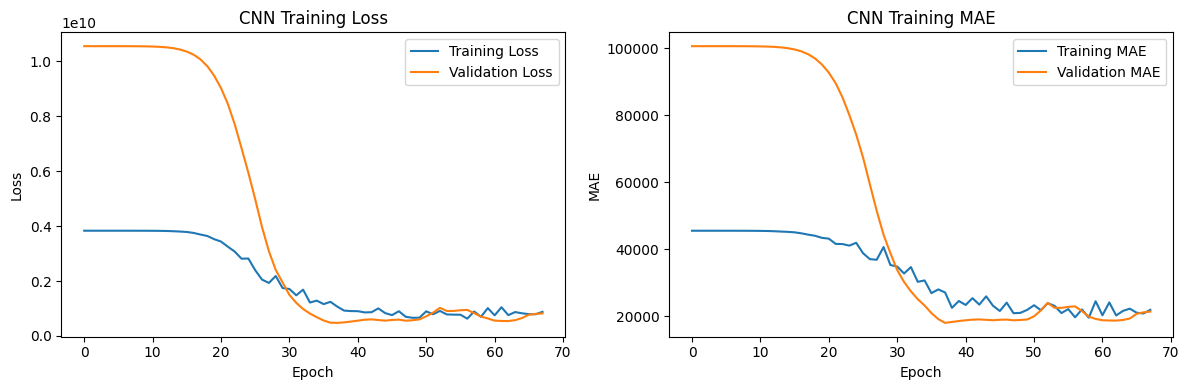

In [56]:
# CNN + SVR Hybrid Model - Combining Temporal CNN with SVR for Enhanced Prediction
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt


class CNNSVRHybrid:
    def __init__(self, cnn_epochs=200, svr_C=100, svr_epsilon=0.1, learning_rate=0.001):
        self.cnn_epochs = cnn_epochs
        self.svr_C = svr_C
        self.svr_epsilon = svr_epsilon
        self.learning_rate = learning_rate
        self.cnn_model = None
        self.svr_model = None
        self.feature_extractor = None
        self.scaler_features = StandardScaler()
        self.scaler_residuals = StandardScaler()
        self.history = None

    def _create_cnn_model(self, input_shape):
        """Create CNN model for feature extraction and initial prediction"""
        inputs = Input(shape=input_shape)

        # Temporal feature extraction layers
        x = Conv1D(filters=32, kernel_size=1, activation='relu')(inputs)
        x = Dropout(0.3)(x)
        x = Conv1D(filters=64, kernel_size=1, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Conv1D(filters=128, kernel_size=1, activation='relu')(x)
        x = Dropout(0.2)(x)

        # Feature extraction branch
        features = Flatten()(x)
        features = Dense(64, activation='relu', name='features')(features)

        # Prediction branch
        prediction = Dense(32, activation='relu')(features)
        prediction = Dropout(0.3)(prediction)
        prediction = Dense(1, name='prediction')(prediction)

        # Create two models: full model and feature extractor
        full_model = Model(inputs, prediction)
        feature_model = Model(inputs, features)

        full_model.compile(
            optimizer=Adam(learning_rate=self.learning_rate),
            loss='mse',
            metrics=['mae']
        )

        return full_model, feature_model

    def fit(self, X_train, y_train, X_val=None, y_val=None, verbose=1):
        """Train the CNN-SVR hybrid model"""
        # Ensure input is in the right shape for CNN
        if len(X_train.shape) == 2:
            X_train_cnn = X_train.reshape(
                X_train.shape[0], X_train.shape[1], 1)
        else:
            X_train_cnn = X_train

        if X_val is not None and len(X_val.shape) == 2:
            X_val_cnn = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
        else:
            X_val_cnn = X_val

        # Step 1: Train CNN model
        print("Step 1: Training CNN for feature extraction and initial prediction...")
        self.cnn_model, self.feature_extractor = self._create_cnn_model(
            X_train_cnn.shape[1:])

        # Set up callbacks
        callbacks = [EarlyStopping(
            monitor='val_loss', patience=30, restore_best_weights=True)]

        # Train CNN
        if X_val_cnn is not None:
            self.history = self.cnn_model.fit(
                X_train_cnn, y_train,
                validation_data=(X_val_cnn, y_val),
                epochs=self.cnn_epochs,
                batch_size=8,
                callbacks=callbacks,
                verbose=verbose
            )
        else:
            self.history = self.cnn_model.fit(
                X_train_cnn, y_train,
                validation_split=0.2,
                epochs=self.cnn_epochs,
                batch_size=8,
                callbacks=callbacks,
                verbose=verbose
            )

        # Step 2: Extract features and CNN predictions
        print("Step 2: Extracting CNN features and computing residuals...")
        cnn_features = self.feature_extractor.predict(X_train_cnn, verbose=0)
        cnn_predictions = self.cnn_model.predict(
            X_train_cnn, verbose=0).ravel()

        # Step 3: Compute residuals
        residuals = y_train - cnn_predictions

        # Step 4: Combine original features with CNN features
        # Flatten original features if needed
        if len(X_train.shape) > 2:
            X_train_flat = X_train.reshape(X_train.shape[0], -1)
        else:
            X_train_flat = X_train

        combined_features = np.hstack([X_train_flat, cnn_features])

        # Scale combined features
        combined_features_scaled = self.scaler_features.fit_transform(
            combined_features)

        # Scale residuals
        residuals_scaled = self.scaler_residuals.fit_transform(
            residuals.reshape(-1, 1)).ravel()

        # Step 5: Train SVR on residuals using combined features
        print("Step 3: Training SVR on residuals using CNN features...")
        self.svr_model = SVR(kernel='rbf', C=self.svr_C,
                             epsilon=self.svr_epsilon, gamma='scale')
        self.svr_model.fit(combined_features_scaled, residuals_scaled)

        print("CNN-SVR Hybrid training completed!")

    def predict(self, X_test):
        """Make predictions using the CNN-SVR hybrid model"""
        # Ensure input is in the right shape for CNN
        if len(X_test.shape) == 2:
            X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
        else:
            X_test_cnn = X_test

        # Get CNN predictions and features
        cnn_predictions = self.cnn_model.predict(X_test_cnn, verbose=0).ravel()
        cnn_features = self.feature_extractor.predict(X_test_cnn, verbose=0)

        # Combine original features with CNN features
        if len(X_test.shape) > 2:
            X_test_flat = X_test.reshape(X_test.shape[0], -1)
        else:
            X_test_flat = X_test

        combined_features = np.hstack([X_test_flat, cnn_features])
        combined_features_scaled = self.scaler_features.transform(
            combined_features)

        # Get SVR residual predictions
        svr_residuals_scaled = self.svr_model.predict(combined_features_scaled)
        svr_residuals = self.scaler_residuals.inverse_transform(
            svr_residuals_scaled.reshape(-1, 1)).ravel()

        # Combine CNN predictions with SVR residual corrections
        final_predictions = cnn_predictions + svr_residuals

        return final_predictions

    def get_component_predictions(self, X_test):
        """Get individual component predictions for analysis"""
        if len(X_test.shape) == 2:
            X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
        else:
            X_test_cnn = X_test

        # CNN component
        cnn_predictions = self.cnn_model.predict(X_test_cnn, verbose=0).ravel()
        cnn_features = self.feature_extractor.predict(X_test_cnn, verbose=0)

        # SVR component
        if len(X_test.shape) > 2:
            X_test_flat = X_test.reshape(X_test.shape[0], -1)
        else:
            X_test_flat = X_test

        combined_features = np.hstack([X_test_flat, cnn_features])
        combined_features_scaled = self.scaler_features.transform(
            combined_features)
        svr_residuals_scaled = self.svr_model.predict(combined_features_scaled)
        svr_residuals = self.scaler_residuals.inverse_transform(
            svr_residuals_scaled.reshape(-1, 1)).ravel()

        return cnn_predictions, svr_residuals

    def plot_training_history(self):
        """Plot CNN training history"""
        if self.history is None:
            print("No training history available")
            return

        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Loss plot
        axes[0].plot(self.history.history['loss'], label='Training Loss')
        axes[0].plot(self.history.history['val_loss'], label='Validation Loss')
        axes[0].set_title('CNN Training Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].legend()

        # MAE plot
        axes[1].plot(self.history.history['mae'], label='Training MAE')
        axes[1].plot(self.history.history['val_mae'], label='Validation MAE')
        axes[1].set_title('CNN Training MAE')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('MAE')
        axes[1].legend()

        plt.tight_layout()
        plt.show()


# Train the CNN-SVR Hybrid Model
print("Training CNN-SVR Hybrid Model...")
print("=" * 50)

# Use the same data preparation as other models
X_cnn_svr = X_scaled.reshape(-1, 1, 1)
y_cnn_svr = y

# Use the same train/test split
X_cnn_svr_train = X_cnn_svr[:len_data//10*9]
X_cnn_svr_test = X_cnn_svr[len_data//10*9:]
y_cnn_svr_train = y_cnn_svr[:len_data//10*9]
y_cnn_svr_test = y_cnn_svr[len_data//10*9:]

# Create and train the hybrid model
cnn_svr_hybrid = CNNSVRHybrid(
    cnn_epochs=300,
    svr_C=100,
    svr_epsilon=1.1,
    learning_rate=0.001
)

cnn_svr_hybrid.fit(X_cnn_svr_train, y_cnn_svr_train, verbose=1)

# Make predictions
y_pred_cnn_svr = cnn_svr_hybrid.predict(X_cnn_svr_test)

# Evaluate the model
mse_cnn_svr = mean_squared_error(y_cnn_svr_test, y_pred_cnn_svr)
r2_cnn_svr = r2_score(y_cnn_svr_test, y_pred_cnn_svr)

print(f"\nCNN-SVR Hybrid Model Results:")
print(f"Mean Squared Error: {mse_cnn_svr:.2f}")
print(f"R-squared: {r2_cnn_svr:.4f}")

# Plot training history
cnn_svr_hybrid.plot_training_history()

/tmp/ipykernel_21136/795154333.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


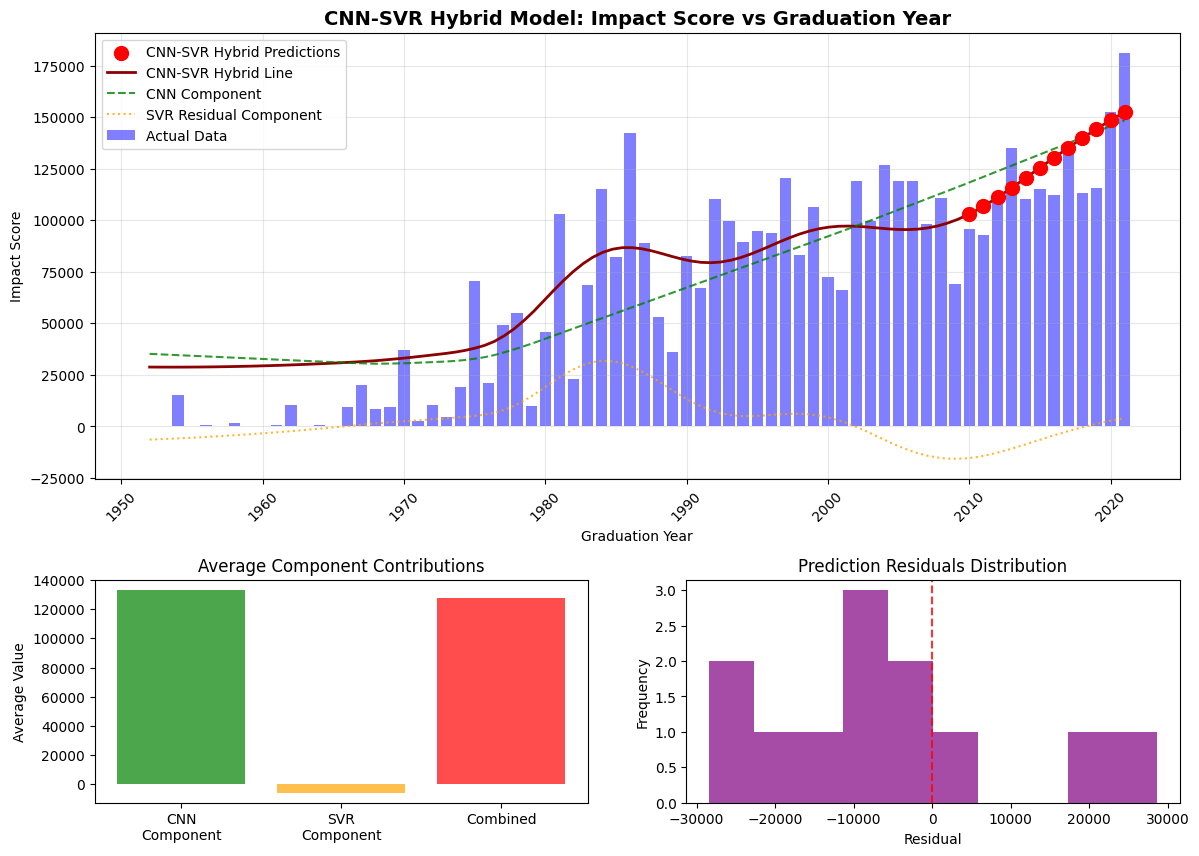


Updated Model Comparison with CNN-SVR Hybrid:
1. Hybrid Model              - MSE: 264662402.32, R²:   0.5517
2. CNN-SVR Hybrid            - MSE: 292578251.64, R²:   0.4865
3. SVR                       - MSE: 359231983.19, R²:   0.3915
4. Neural-SVR Hybrid         - MSE: 395298807.74, R²:   0.3304
5. Improved CNN              - MSE: 440372464.29, R²:   0.2271
6. Linear Regression         - MSE: 453752837.85, R²:   0.2314
7. Random Forest             - MSE: 877681461.92, R²:  -0.4867

Hybrid Model Performance Analysis:
Improvement over standalone CNN: 33.56%
Improvement over standalone SVR: 18.55%

Component Analysis on Test Set:
CNN component range: 118307.8 to 148474.8
SVR component range: -15341.0 to 3980.8
CNN component contribution: 133329.7 (avg absolute)
SVR component contribution: 6938.3 (avg absolute)


In [57]:
# Visualize CNN-SVR Hybrid Model Results
plt.figure(figsize=(14, 10))

# Create subplot layout
gs = plt.GridSpec(2, 2, height_ratios=[2, 1], hspace=0.3)

# Main prediction plot
ax1 = plt.subplot(gs[0, :])

# Plot actual data
ax1.bar(years, y, color='blue', alpha=0.5, label='Actual Data', width=0.8)

# Plot test predictions
X_test_years = scaler.inverse_transform(X_cnn_svr_test.reshape(-1, 1))
ax1.scatter(X_test_years.flatten(), y_pred_cnn_svr,
            color='red', s=100, label='CNN-SVR Hybrid Predictions', zorder=5)

# Plot prediction line for full range
X_range = np.linspace(years.min(), years.max(), 100).reshape(-1, 1)
X_range_scaled = scaler.transform(X_range).reshape(-1, 1, 1)
y_range_pred_cnn_svr = cnn_svr_hybrid.predict(X_range_scaled)
ax1.plot(X_range.flatten(), y_range_pred_cnn_svr,
         color='darkred', linewidth=2, label='CNN-SVR Hybrid Line')

# Get component predictions for visualization
cnn_component, svr_component = cnn_svr_hybrid.get_component_predictions(
    X_range_scaled)

ax1.plot(X_range.flatten(), cnn_component,
         color='green', linewidth=1.5, linestyle='--', alpha=0.8, label='CNN Component')
ax1.plot(X_range.flatten(), svr_component,
         color='orange', linewidth=1.5, linestyle=':', alpha=0.8, label='SVR Residual Component')

ax1.set_title('CNN-SVR Hybrid Model: Impact Score vs Graduation Year',
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Graduation Year')
ax1.set_ylabel('Impact Score')
ax1.legend()
ax1.grid(alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Component analysis subplot
ax2 = plt.subplot(gs[1, 0])
test_cnn_comp, test_svr_comp = cnn_svr_hybrid.get_component_predictions(
    X_cnn_svr_test)
ax2.bar(['CNN\nComponent', 'SVR\nComponent', 'Combined'],
        [np.mean(test_cnn_comp), np.mean(
            test_svr_comp), np.mean(y_pred_cnn_svr)],
        color=['green', 'orange', 'red'], alpha=0.7)
ax2.set_title('Average Component Contributions')
ax2.set_ylabel('Average Value')

# Prediction accuracy subplot
ax3 = plt.subplot(gs[1, 1])
residuals_cnn_svr = y_cnn_svr_test - y_pred_cnn_svr
ax3.hist(residuals_cnn_svr, bins=10, alpha=0.7, color='purple')
ax3.set_title('Prediction Residuals Distribution')
ax3.set_xlabel('Residual')
ax3.set_ylabel('Frequency')
ax3.axvline(0, color='red', linestyle='--', alpha=0.8)

plt.tight_layout()
plt.show()

# Add CNN-SVR Hybrid to model comparison
models['CNN-SVR Hybrid'] = (mse_cnn_svr, r2_cnn_svr)

print("\nUpdated Model Comparison with CNN-SVR Hybrid:")
print("=" * 65)
sorted_models = sorted(models.items(), key=lambda x: x[1][0])  # Sort by MSE
for i, (model_name, (mse_value, r2_value)) in enumerate(sorted_models, 1):
    print(f"{i}. {model_name:25} - MSE: {mse_value:10.2f}, R²: {r2_value:8.4f}")

# Show improvement analysis
standalone_cnn_mse = models['Improved CNN'][0]
standalone_svr_mse = models['SVR'][0]
improvement_over_cnn = (
    (standalone_cnn_mse - mse_cnn_svr) / standalone_cnn_mse) * 100
improvement_over_svr = (
    (standalone_svr_mse - mse_cnn_svr) / standalone_svr_mse) * 100

print(f"\nHybrid Model Performance Analysis:")
print(f"Improvement over standalone CNN: {improvement_over_cnn:.2f}%")
print(f"Improvement over standalone SVR: {improvement_over_svr:.2f}%")

# Detailed component analysis
print(f"\nComponent Analysis on Test Set:")
print(
    f"CNN component range: {test_cnn_comp.min():.1f} to {test_cnn_comp.max():.1f}")
print(
    f"SVR component range: {test_svr_comp.min():.1f} to {test_svr_comp.max():.1f}")
print(
    f"CNN component contribution: {np.mean(np.abs(test_cnn_comp)):.1f} (avg absolute)")
print(
    f"SVR component contribution: {np.mean(np.abs(test_svr_comp)):.1f} (avg absolute)")

Generating future predictions with CNN-SVR Hybrid Model...

Future Predictions (2022-2046):
Year	CNN		SVR		Combined
--------------------------------------------------
2022	151247.2	  5028.0	156275.2
2023	154019.7	  5892.0	159911.7
2024	156792.1	  6593.0	163385.1
2025	159564.6	  7152.0	166716.6
2026	162337.0	  7590.0	169927.0
2027	165109.4	  7927.1	173036.5
2028	167881.9	  8181.6	176063.5
2029	170654.3	  8370.2	179024.5
2030	173426.8	  8507.1	181933.9
2031	176199.2	  8604.6	184803.8


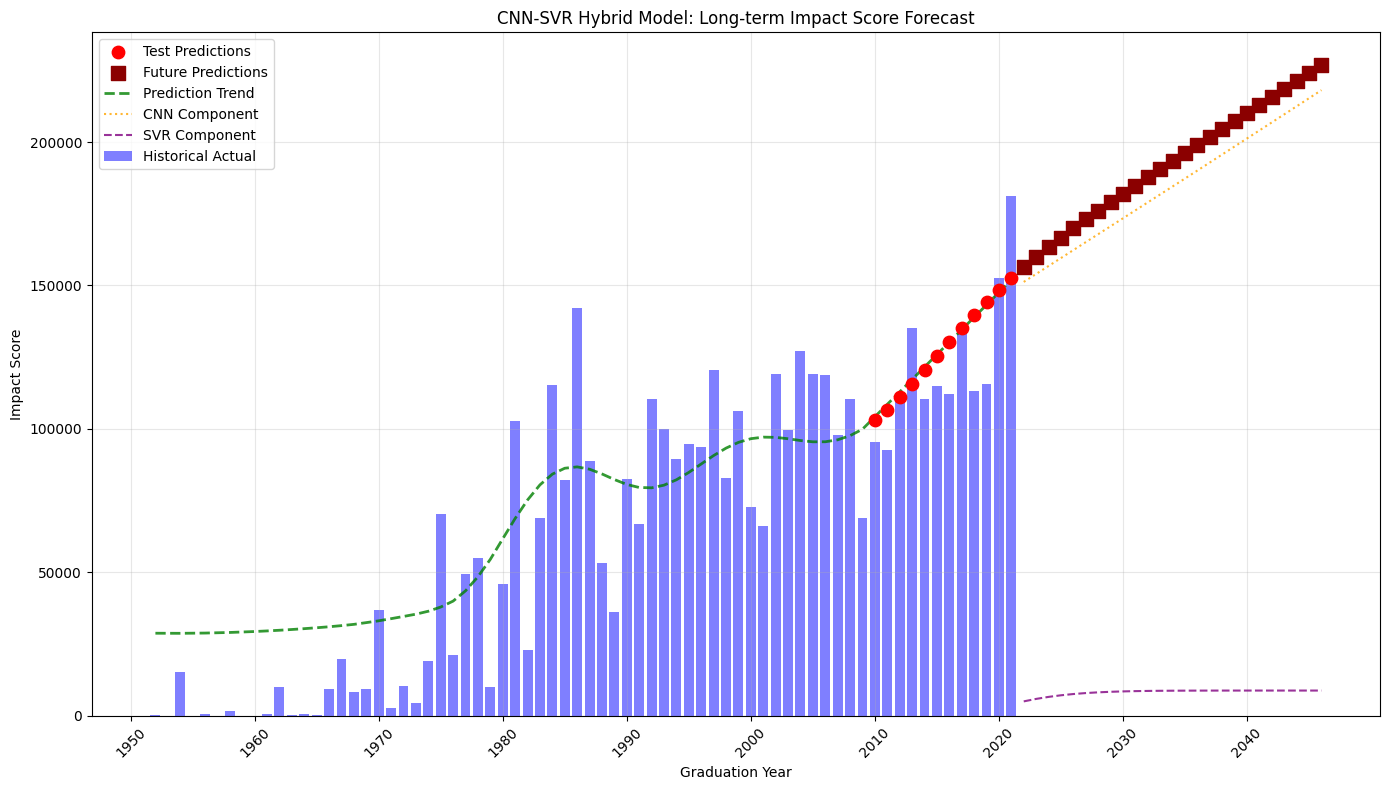

In [ ]:
# predict future values with CNN-SVR Hybrid Model
print("Generating future predictions with CNN-SVR Hybrid Model...")
# Predict future years
last_year = years.max()
future_years_cnn_svr = np.arange(last_year + 1, last_year + 26).reshape(-1, 1)
future_years_cnn_svr_scaled = scaler.transform(
    future_years_cnn_svr).reshape(-1, 1, 1)
# Get hybrid predictions
future_predictions_cnn_svr = cnn_svr_hybrid.predict(
    future_years_cnn_svr_scaled)
# Get component predictions for analysis
future_cnn_component, future_svr_component = cnn_svr_hybrid.get_component_predictions(
    future_years_cnn_svr_scaled)
print("\nFuture Predictions (2022-2046):")
print("Year\tCNN\t\tSVR\t\tCombined")
print("-" * 50)
for i, year in enumerate(future_years_cnn_svr.flatten()):
    if i < 10:  # Show first 10 years
        print(
            f"{year}\t{future_cnn_component[i]:8.1f}\t{future_svr_component[i]:8.1f}\t{future_predictions_cnn_svr[i]:8.1f}")
# Visualization of future predictions
plt.figure(figsize=(14, 8))
# Historical data
plt.bar(years, y, color='blue', alpha=0.5,
        label='Historical Actual', width=0.8)
# Historical test predictions
plt.scatter(X_test_years.flatten(), y_pred_cnn_svr,
            color='red', s=80, label='Test Predictions', zorder=5)
# Future predictions
plt.scatter(future_years_cnn_svr.flatten(), future_predictions_cnn_svr,
            color='darkred', s=100, marker='s', label='Future Predictions', zorder=10)
# Trend lines
all_years_cnn_svr_scaled = np.vstack(
    [X_cnn_svr_train, future_years_cnn_svr_scaled])
all_predictions_cnn_svr = cnn_svr_hybrid.predict(all_years_cnn_svr_scaled)
all_years_cnn_svr_orig = scaler.inverse_transform(
    all_years_cnn_svr_scaled.reshape(-1, 1)).flatten()

plt.plot(all_years_cnn_svr_orig, all_predictions_cnn_svr,
         'g--', linewidth=2, alpha=0.8, label='Prediction Trend')
# Component analysis for future
plt.plot(future_years_cnn_svr.flatten(), future_cnn_component,
         'orange', linewidth=1.5, linestyle=':', alpha=0.8, label='CNN Component')
plt.plot(future_years_cnn_svr.flatten(), future_svr_component,
         'purple', linewidth=1.5, linestyle='--', alpha=0.8, label='SVR Component')
plt.title('CNN-SVR Hybrid Model: Long-term Impact Score Forecast')
plt.xlabel('Graduation Year')
plt.ylabel('Impact Score')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(np.arange(1950, 2050, 10), rotation=45)
plt.tight_layout()
plt.show()